In [1]:
#default_exp ch01_problem02

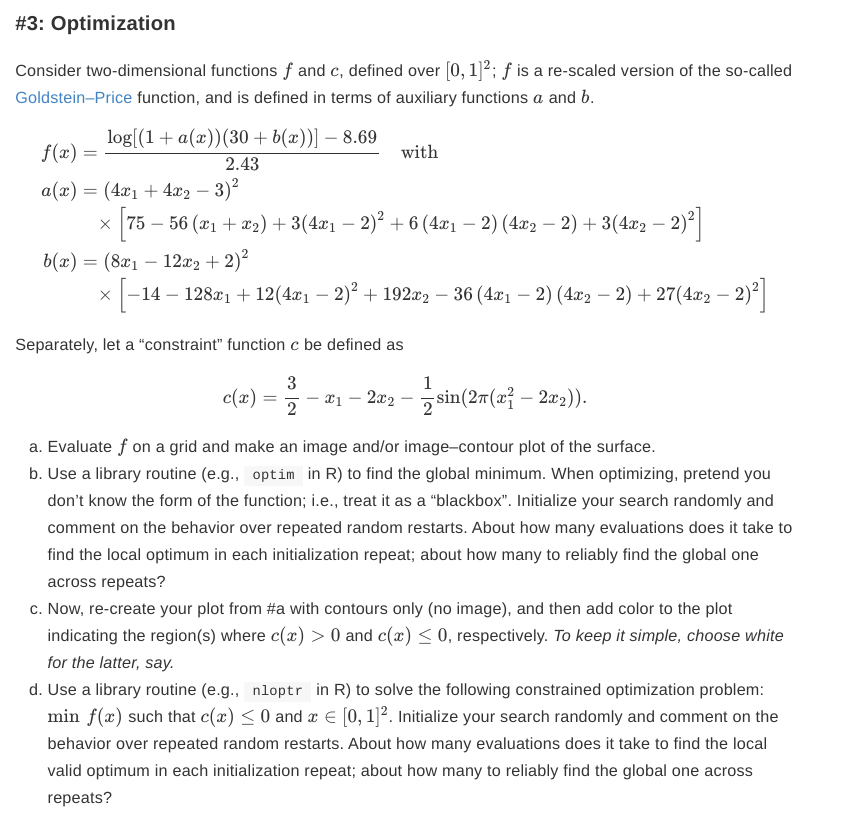

In [2]:
%config Completer.use_jedi = False

In [3]:
import pandas as pd
import numpy as np
import pyDOE
from mpl_toolkits import mplot3d
import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

In [19]:
FIGSIZE = (10, 8)

def goldstein_price(x):
    x1, x2 = x[0], x[1]
    log_arg = (1 + a(x)) * (30 + b(x))
    numerator = np.log(log_arg) - 8.69
    return numerator / 2.43

def a(x):
    x1, x2 = x[0], x[1]
    left_term = (4*x1 + 4*x2 - 3)**2
    right_term = (
        75 - 
        56 * (x1 + x2) + 
        3*(4*x1 - 2)**2 +
        6*(4*x1 - 2)*(4*x2 - 2) +
        27*(4*x2 - 2)**2)
    return left_term * right_term

def b(x):
    x1, x2 = x[0], x[1]
    left_term = (8*x1 - 12*x2 + 2)**2
    right_term = (
        -14 -
        128*x1 +
        12*(4*x1 - 2)**2 +
        192*x2 - 
        36*(4*x1 - 2)*(4*x2 - 2) +
        27*(4*x2 - 2)**2)
    return left_term * right_term
    
def c(x):
    x1, x2 = x[0], x[1]
    return (
    3/2 -
    x1 -
    2*x2 -
    0.5*np.sin(2*np.pi * 
               (x1**2 - 2*x2)))


def attach_error_distances(grid_df: pd.DataFrame, name: str, 
                           mins: np.array, global_min: np.array) -> None:
    assert name in ('unconstrained', 'constrained')
    error_names = []
    for var in (0, 1):
        variable = f'{name}_minimizing_x{var + 1}'
        grid_df[variable] = [mins[i][var] for i in range(len(mins))]
        error_names.append(variable)
    grid_df[f'{name}_min_error'] = grid_df.apply(
        lambda row:  np.linalg.norm(np.array(row[error_names]) - global_min), 
        axis=1)

In [5]:
variables = ['x1', 'x2']
grid_matrix = pyDOE.lhs(2, samples=1000*2)
grid_df = pd.DataFrame(grid_matrix, columns=variables)
grid_df['y'] = grid_df.apply(lambda row: goldstein_price(np.array(row)), axis=1)
grid_df['c'] = grid_df.apply(lambda row: c(np.array(row)), axis=1)

display(grid_df.head())

,x1,x2,y,c
0,0.002531,0.963701,2.584641,-0.650198
1,0.891971,0.480667,-1.253988,0.078217
2,0.253205,0.473056,-1.332743,-0.036984
3,0.405016,0.356925,-2.074843,0.227185
4,0.020733,0.701984,0.386379,0.360130


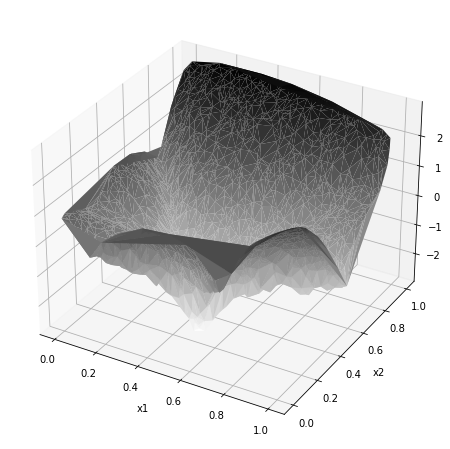

In [20]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes(projection='3d')
ax.plot_trisurf(grid_df['x1'], grid_df['x2'], grid_df['y'], cmap='binary')
#ax.plot_trisurf(grid_df['x1'], grid_df['x2'], grid_df['c'])
ax.set_xlabel('x1')
ax.set_ylabel('x2');

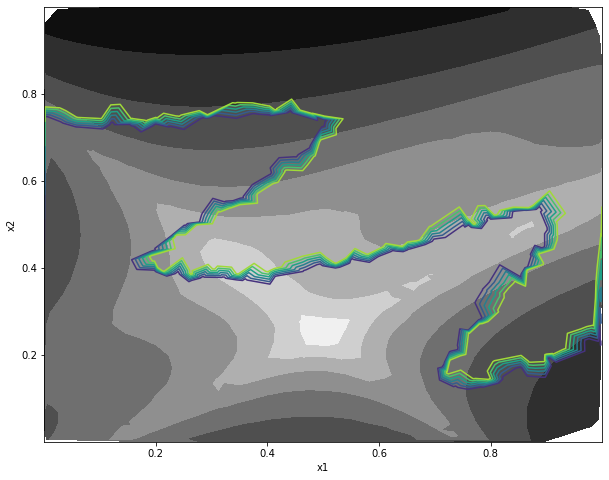

In [21]:
fig = plt.figure(figsize=FIGSIZE)
ax = plt.axes()
plt.tricontourf(grid_df['x1'], grid_df['x2'], grid_df['y'], cmap='binary')
plt.tricontour(grid_df['x1'], grid_df['x2'], grid_df['c'] <= 0, alpha=1)
ax.set_xlabel('x1')
ax.set_ylabel('x2');

In [8]:
global_min = np.array([0.5, 0.25])
x0 = np.array([0.35, 0.9]) # (0.35, 0.4)
x0 = np.array([0.35, 0.2]) # (0.5, 0.25)
# There's a local minimum at 0.35, 0.4. You can't see it on the contour, 
# but rotating the 3d plot finds it.

result = scipy.optimize.minimize(goldstein_price, x0=x0)

In [9]:
unconstrained_mins = grid_df.apply(
    lambda row: scipy.optimize.minimize(goldstein_price, x0=np.array(row[variables])).x,
    axis=1)
attach_error_distances(grid_df, "unconstrained", unconstrained_mins, global_min=global_min)

### The error in the minimum, based on where in the space we started. 
Not averaged or anything, so might be a bit subject to the RNG.

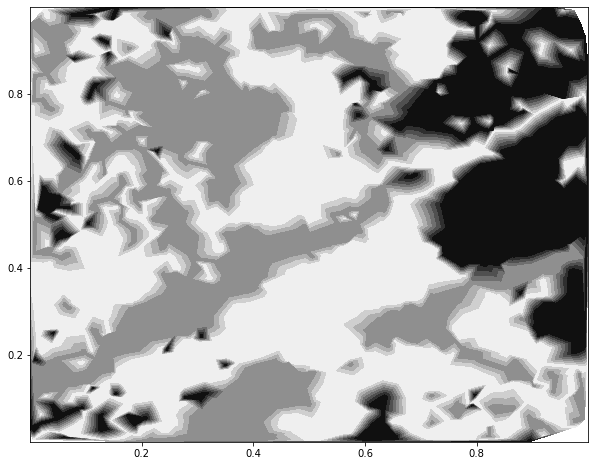

In [22]:
fig = plt.figure(figsize=FIGSIZE)
#ax = plt.axes(projection='3d')
#ax.plot_trisurf(grid_df['x1'], grid_df['x2'], grid_df['unconstrained_min_error'], cmap='binary')
plt.tricontourf(grid_df['x1'], grid_df['x2'], grid_df['unconstrained_min_error'], cmap='binary')
ax.set_xlabel('x1')
ax.set_ylabel('x2');

## For the constrained problem.

In [14]:
constraint = scipy.optimize.NonlinearConstraint(lambda x: float(c(x) < 0), lb=0, ub=1)
result = scipy.optimize.minimize(goldstein_price, x0=x0, method="trust-constr", 
                                 constraints=constraint)

In [12]:
constrained_mins = grid_df.apply(
    lambda row: scipy.optimize.minimize(
        goldstein_price, x0=np.array(row[variables]),
        constraints=constraint).x,
    axis=1)
attach_error_distances(grid_df, "constrained", constrained_mins, global_min=global_min)

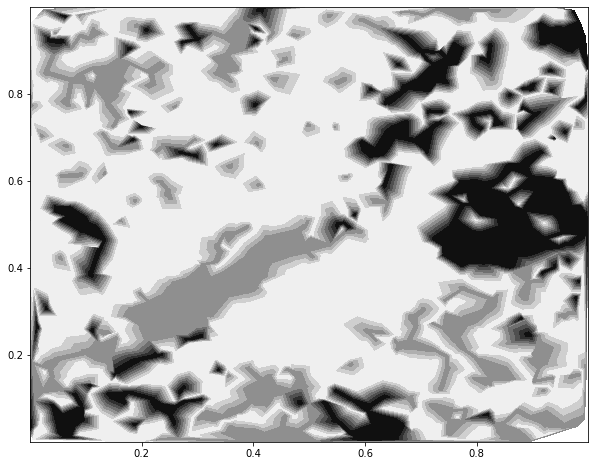

In [23]:
fig = plt.figure(figsize=FIGSIZE)
plt.tricontourf(grid_df['x1'], grid_df['x2'], grid_df['constrained_min_error'], cmap='binary')
ax.set_xlabel('x1')
ax.set_ylabel('x2');

Looks like the constraint made it easier! More hot-white, which is the minimum error color. Eyeing the white area of each contour plot, it looks like the minimizer finds the global minimum for around half of the initialization values in the unit square for the unconstrained problem; and for the constrained problem, 80% of the initialization values.